In [1]:
import numpy as np
import sys
import h5py as h5
import tables
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2
from scipy.fft import fft, ifft

import tqdm

import sys, os
from pathlib import Path

import psana as ps

plt.rcParams['figure.figsize'] = (8, 6)
plt.rc('font', size=15)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

# import gdown


In [105]:
from pathlib import Path


run = 775 # The experiment run to analyze,228  234
exp = 'xppc00121'
h5dir = Path('/sdf/home/o/ohoidn/data')
fname = '{}_Run{:04d}.h5'.format(exp,run)
fname = h5dir / fname
print(fname)


f = h5.File(fname, 'r')
fname

print('\n'.join(f.keys()))

rr = tables.open_file(fname).root
rr.scan # scan variable

rr.UserDataCfg.jungfrau1M

rr.UserDataCfg.jungfrau1M.ROI_0__ROI_0_ROI[()] # ROI used for generating the Small Data

idx_tile = rr.UserDataCfg.jungfrau1M.ROI_0__ROI_0_ROI[()][0,0]

rr.ipm2 # I0, positional parameters matter

rr.Sums.jungfrau1M_calib

print(rr.jungfrau1M.ROI_0_area.shape)

im_tiles = rr.Sums.jungfrau1M_calib

# roi_crop = [5,160,40,240]
roi_crop = [70,100,65,100]
roi_crop = [70,130,65,130]
roi_crop = [0,150,0,150]

E0 = 11.9 # X-ray energy
thresh_1,thresh_2 = E0-1.,E0+1.
thresh_3,thresh_4 = 2*E0-1.,2*E0+1.
thresh_5,thresh_6 = 3*E0-1.,3*E0+1.


fim = rr.jungfrau1M.ROI_0_area[:10000,roi_crop[0]:roi_crop[1],roi_crop[2]:roi_crop[3]].ravel()

imgs_thresh = rr.jungfrau1M.ROI_0_area[:,roi_crop[0]:roi_crop[1],roi_crop[2]:roi_crop[3]]


imgs_thresh[imgs_thresh<4.] = 0


idx_on = np.where(np.array(rr.evr.code_90)==1.)[0]
idx_off = np.where(np.array(rr.evr.code_91)==1.)[0]
idx_on.shape,idx_off.shape

xvar=rr.enc.lasDelay2 + np.array(rr.tt.FLTPOS_PS)*0.
xvar= np.round(xvar)

xvar_unique = np.array(list(set(xvar)))
idx_nan = np.where(np.isnan(xvar_unique)==1.)
xvar_unique = np.delete(xvar_unique,idx_nan)
xvar_unique.shape,xvar_unique

xvar_unique.sort()
xvar_unique,xvar_unique.shape

xvar_unique = np.linspace(xvar_unique.min(),xvar_unique.max(),33)
print(xvar_unique)


xvar=rr.enc.lasDelay2 + np.array(rr.tt.FLTPOS_PS)*0
for i in range(len(xvar)):
    if np.isnan(xvar[i])==True:
        continue
    diff = abs(xvar[i]-xvar_unique)
    idx = np.where(diff==diff.min())[0][0]
    xvar[i] = xvar_unique[idx]

I0_thres = 200 # thresholding the I0 monitor
I0_a = rr.ipm2.sum[:]

I0_x = rr.ipm2.xpos[:]
I0_y = rr.ipm2.ypos[:]

xc = -0.08
yc = -0.28
arg = (I0_x<(xc+0.2))&(I0_x>(xc-0.2))&(I0_y<(yc+0.5))&(I0_y>(yc-0.5))


mask = rr.UserDataCfg.jungfrau1M.mask[idx_tile][rr.UserDataCfg.jungfrau1M.ROI_0__ROI_0_ROI[()][1,0]:rr.UserDataCfg.jungfrau1M.ROI_0__ROI_0_ROI[()][1,1],rr.UserDataCfg.jungfrau1M.ROI_0__ROI_0_ROI[()][2,0]:rr.UserDataCfg.jungfrau1M.ROI_0__ROI_0_ROI[()][2,1]]

imgs_thresh.shape

im = imgs_thresh[(I0_a>I0_thres)&(np.array(rr.evr.code_90)==1.),:,:].mean(axis=0)
im = im*mask[roi_crop[0]:roi_crop[1],roi_crop[2]:roi_crop[3]]

im1 = imgs_thresh[(I0_a>I0_thres)&(np.array(rr.evr.code_91)==1.),:,:].mean(axis=0)
im1 = im1*mask[roi_crop[0]:roi_crop[1],roi_crop[2]:roi_crop[3]]


roi = [180,200,170,230]
roi = [155,175,100,150]
roi = [184,193,120,170]
roi = [40,60,85,130]
roi = [0,im.shape[0]-30,0,im.shape[1]-30]
cdw_mask = np.zeros_like(im)
cdw_mask[roi[0]:roi[1],roi[2]:roi[3]] = 1.
print(roi)

ims_crop = imgs_thresh

I = ims_crop.mean(axis=(1,2))


/sdf/home/o/ohoidn/data/xppc00121_Run0775.h5
Sums
UserDataCfg
adc
ai
damage
diode2
diodeU
ebeam
enc
epics
epicsAll
event_time
evr
feeBld
fiducials
ipm2
ipm_hx2
jungfrau1M
lightStatus
lombpm
lomdiode
scan
tt
(76265, 156, 151)
[-10.  -5.   0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.
  60.  65.  70.  75.  80.  85.  90.  95. 100. 105. 110. 115. 120. 125.
 130. 135. 140. 145. 150.]
[0, 120, 0, 120]


In [ ]:
%%time

# %run histogram_analysis.py
from lcls.histogram_analysis import *

from scipy.stats import wasserstein_distance
from scipy.ndimage import label

data = imgs_thresh#[:7000, ...]#load_data(filepath)
histograms = calculate_histograms(data, bin_boundaries, hist_start_bin)

tmp = histograms.copy()
histograms = tmp.copy()

import numpy as np
from scipy.ndimage import distance_transform_edt

def set_nearest_neighbors(histograms, mask, roi_crop):
    # Extract the ROI from the mask
    roi_mask = mask[roi_crop[0]:roi_crop[1], roi_crop[2]:roi_crop[3]]

    # Invert the mask for distance transform
    inverted_mask = 1 - roi_mask

    # Compute the distance transform
    distance, (indices_y, indices_x) = distance_transform_edt(inverted_mask, return_indices=True)

    # Set the values in histograms based on the nearest neighbor indices
    zero_positions = np.where(roi_mask == 0)
    for y, x in zip(*zero_positions):
        nearest_y, nearest_x = indices_y[y, x], indices_x[y, x]
        # Copying the entire slice along the 0th dimension
        histograms[:, roi_crop[0] + y, roi_crop[2] + x] = histograms[:, roi_crop[0] + nearest_y, roi_crop[2] + nearest_x]


set_nearest_neighbors(histograms, mask, roi_crop)

plt.imshow(histograms.sum(axis = 0))
plt.colorbar()

threshold = .000001
# Run the analysis
res = run_histogram_analysis(
    bin_boundaries = bin_boundaries, hist_start_bin = hist_start_bin,
    roi_x_start = roi_x_start, roi_x_end = roi_x_end, roi_y_start = roi_y_start,
    roi_y_end = roi_y_end, histograms = histograms,
    threshold = threshold, num_permutations=1000)
signal_mask = res['signal_mask']
plt.imshow(signal_mask)

In [150]:
from scipy.ndimage import binary_erosion, generate_binary_structure
def erode_signal_mask(signal_mask, iterations=1, structure=None):
    """
    Apply binary erosion to a signal mask.

    Parameters:
    - signal_mask: 2D numpy array of boolean values (True/False or 1/0).
    - iterations: int, the number of times to erode the mask.
    - structure: 2D array, structuring element used for the erosion. 
                 If None, a cross-shaped structure is used by default.

    Returns:
    - eroded_signal_mask: 2D numpy array, eroded signal mask.
    """
    if structure is None:
        structure = generate_binary_structure(2, 1)  # 2D cross-shaped structure

    eroded_signal_mask = binary_erosion(signal_mask, structure=structure, iterations=iterations)
    return eroded_signal_mask

signal_mask = erode_signal_mask(signal_mask, 20)

In [151]:
# ims_group,ims_group_off = [],[]
# scan_motor = []
# for i in range(len(xvar_unique)):
#     idx = np.where(arg&(I>0.0)&(xvar==xvar_unique[i])&(I0_a>I0_thres)&(I0_a<15000)&(np.array(rr.evr.code_90)==1.))[0]
#     # print()
#     idx_off = np.where(arg&(I>0.0)&(xvar==xvar_unique[i])&(I0_a>I0_thres)&(I0_a<15000)&(np.array(rr.evr.code_91)==1.))[0]
#     print(xvar_unique[i],len(idx),len(idx_off))
#     if (len(idx)>0)&(len(idx_off)>0):
#         # print(len(idx))
#         ims_group.append((ims_crop[idx].mean(axis=0)/I0_a[idx].mean(axis=0))*mask[roi_crop[0]:roi_crop[1],roi_crop[2]:roi_crop[3]])
#         ims_group_off.append((ims_crop[idx_off].mean(axis=0)/I0_a[idx_off].mean(axis=0))*mask[roi_crop[0]:roi_crop[1],roi_crop[2]:roi_crop[3]])
#         scan_motor.append(xvar_unique[i])
# ims_group = np.array(ims_group)
# ims_group_off = np.array(ims_group_off)
# scan_motor = np.array(scan_motor)
# ims_group.shape,scan_motor.shape

# Intensity = ims_group.mean(axis=(1,2))
# std = ims_group.std(axis=(1,2))/np.sqrt(ims_group.shape[1]*ims_group.shape[2])
# bg = ims_group_off.mean(axis=(1,2))

ims_group, ims_group_off = [], []
scan_motor = []
for i in range(len(xvar_unique)):
    idx = np.where(arg & (I > 0.0) & (xvar == xvar_unique[i]) & (I0_a > I0_thres) & (I0_a < 15000) & (np.array(rr.evr.code_90) == 1.))[0]
    idx_off = np.where(arg & (I > 0.0) & (xvar == xvar_unique[i]) & (I0_a > I0_thres) & (I0_a < 15000) & (np.array(rr.evr.code_91) == 1.))[0]

    if (len(idx) > 0) & (len(idx_off) > 0):
        # For each image, apply the mask and then calculate the mean
        mean_on = np.array([np.mean(image[signal_mask]) for image in ims_crop[idx]])
        mean_off = np.array([np.mean(image[signal_mask]) for image in ims_crop[idx_off]])

        # Append the mean values normalized by the mean of I0_a
        ims_group.append(mean_on / I0_a[idx].mean())
        ims_group_off.append(mean_off / I0_a[idx_off].mean())

        scan_motor.append(xvar_unique[i])


# Assuming ims_group and ims_group_off are lists of mean values

# Calculate Intensity, Standard Deviation, and Background for each group

# For ims_group
Intensity = np.array([np.mean(group) for group in ims_group])
std = np.array([np.std(group) / np.sqrt(group.size) for group in ims_group])

# For ims_group_off
bg = np.array([np.mean(group) for group in ims_group_off])

# If you need overall statistics
overall_intensity_mean = Intensity.mean()
overall_std_mean = std.mean()
overall_bg_mean = bg.mean()

def func(x,a,c,w,k1,k0):
    return lorz(x,a,c,w)+k1*x+k0


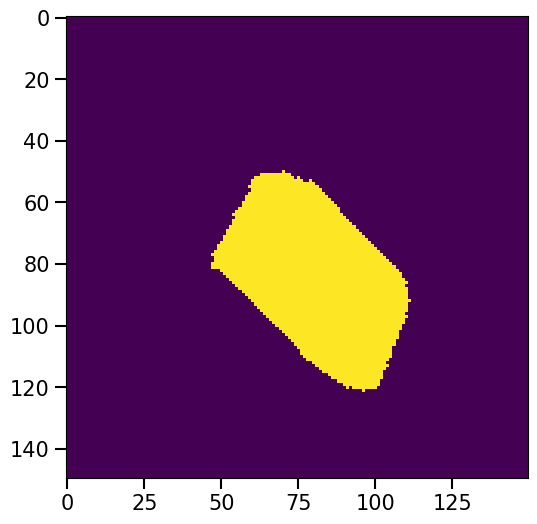

In [153]:
plt.imshow(signal_mask)

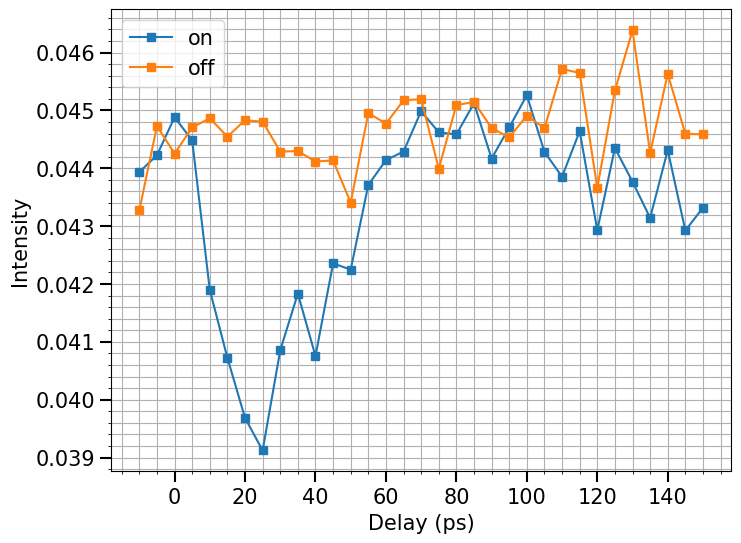

In [152]:
d = -1
plt.plot(scan_motor[:],Intensity[:],'s-',label='on')

plt.plot(scan_motor[:],bg[:],'s-',label='off')

plt.legend()

plt.minorticks_on()
plt.grid(True,'both')
plt.xlabel('Delay (ps)')
plt.ylabel('Intensity')
plt.show()

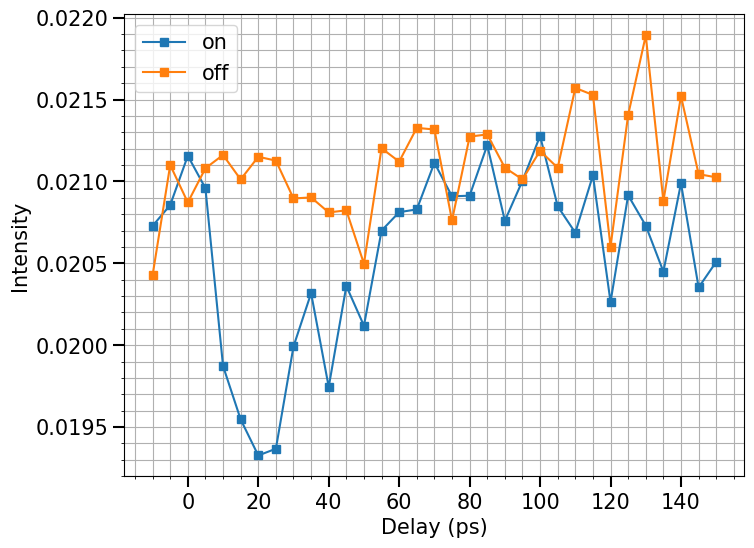

In [144]:
d = -1
plt.plot(scan_motor[:],Intensity[:],'s-',label='on')

plt.plot(scan_motor[:],bg[:],'s-',label='off')

plt.legend()

plt.minorticks_on()
plt.grid(True,'both')
plt.xlabel('Delay (ps)')
plt.ylabel('Intensity')
plt.show()

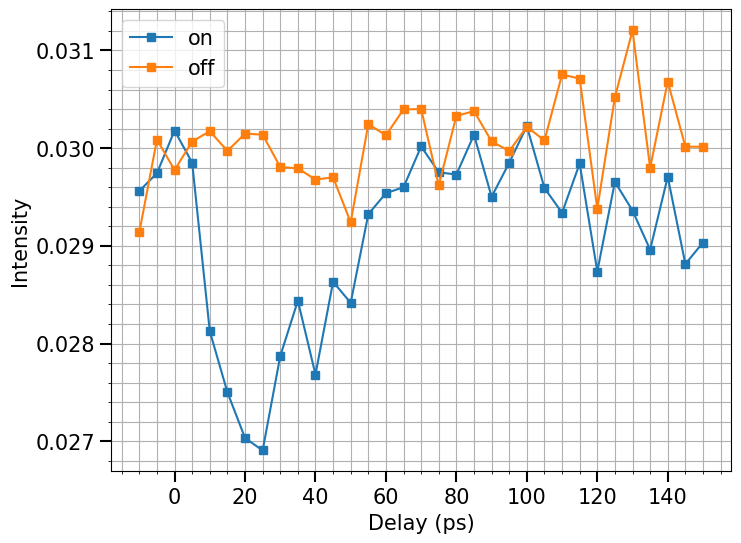

In [99]:
d = -1
plt.plot(scan_motor[:],Intensity[:],'s-',label='on')

plt.plot(scan_motor[:],bg[:],'s-',label='off')

plt.legend()

plt.minorticks_on()
plt.grid(True,'both')
plt.xlabel('Delay (ps)')
plt.ylabel('Intensity')
plt.show()

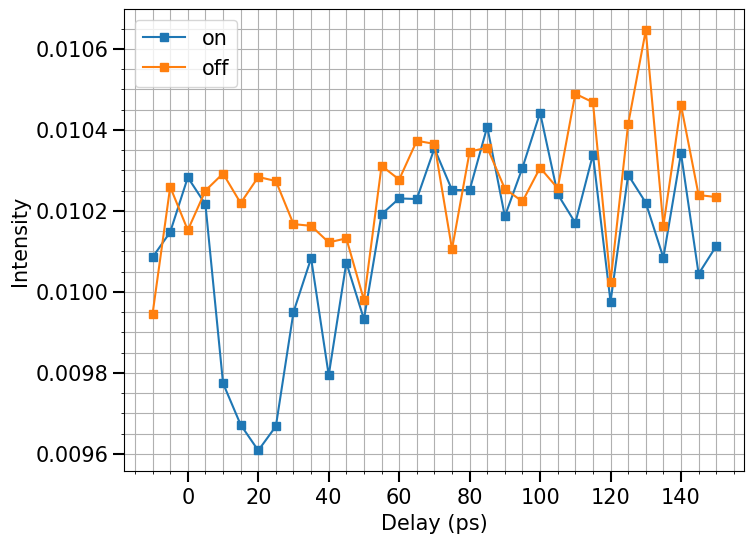

In [92]:
d = -1
plt.plot(scan_motor[:],Intensity[:],'s-',label='on')

plt.plot(scan_motor[:],bg[:],'s-',label='off')

plt.legend()

plt.minorticks_on()
plt.grid(True,'both')
plt.xlabel('Delay (ps)')
plt.ylabel('Intensity')
plt.show()

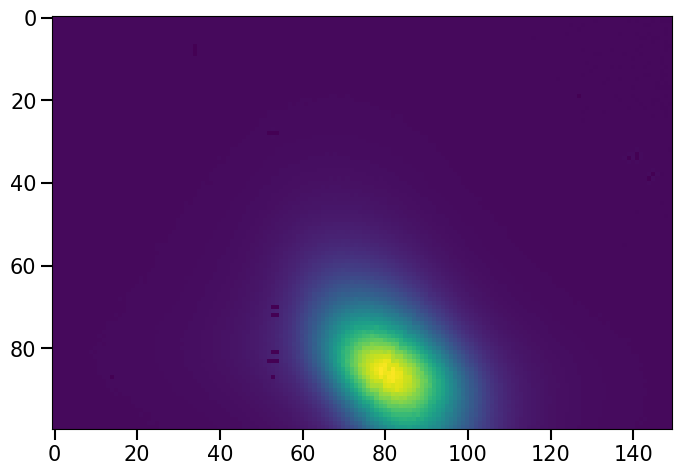

In [4]:
plt.imshow(imgs_thresh.mean(axis = 0))

In [33]:

import numpy as np
from pathlib import Path
import h5py as h5
import tables

def CDW_PP_2(Run_Number, ROI, Energy_Filter, I0_Threshold, IPM_pos_Filter, Time_bin, TimeTool,
             min_count=200):
    # Data Loading and Preparation from Script A
    run = Run_Number
    exp = 'xppc00121'  # Assuming the experiment identifier
    h5dir = Path('/sdf/home/o/ohoidn/data')
    fname = '{}_Run{:04d}.h5'.format(exp, run)
    fname = h5dir / fname

    f = h5.File(fname, 'r')
    rr = tables.open_file(fname).root

    # IPM Positional Filter and I0 Thresholding
    I0_a = rr.ipm2.sum[:]
    I0_x = rr.ipm2.xpos[:]
    I0_y = rr.ipm2.ypos[:]
    xc, yc = -0.08, -0.28  # example center positions, can be adjusted
    arg_I0 = (I0_a >= I0_Threshold) & ((I0_x<(xc+0.2))&(I0_x>(xc-0.2))&(I0_y<(yc+0.5))&(I0_y>(yc-0.5)))
    
    # Time Tool Logic
    tt_arg = TimeTool[0]
    delay = np.array(rr.enc.lasDelay2) + np.array(rr.tt.FLTPOS_PS) * tt_arg
    arg_delay_nan = np.isnan(delay)

    # Binning the Delays
    binned_delays = delay_bin(delay, np.array(rr.enc.lasDelay2), Time_bin, arg_delay_nan)

    # Laser On/Off Logic Modified with I0 Threshold
    arg_laser_on = (np.array(rr.evr.code_90) == 1.) & arg_I0
    arg_laser_off = (np.array(rr.evr.code_91) == 1.) & arg_I0


    # Energy Filtering (Placeholder, needs actual implementation)
    # TODO mask might interfere with p value calculation
    imgs = rr.jungfrau1M.ROI_0_area[:, ROI[0]:ROI[1], ROI[2]:ROI[3]] * mask[ROI[0]:ROI[1], ROI[2]:ROI[3]]  # Using ROI provided as input

    # Extract Stacks by Delay
    stacks_on = extract_stacks_by_delay(binned_delays[arg_laser_on], imgs[arg_laser_on], Time_bin, min_count)
    stacks_off = extract_stacks_by_delay(binned_delays[arg_laser_off], imgs[arg_laser_off], Time_bin, min_count)

    # Return the structured data
    return {
        'stacks_on': stacks_on,
        'stacks_off': stacks_off,
        'I0': I0_a,
        'binned_delays': binned_delays,
        'arg_laser_on': arg_laser_on,
        'arg_laser_off': arg_laser_off
    }


In [101]:
from ybco import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
from scipy.io import savemat
import numpy as np

In [35]:
%%time

# Redefine bin boundaries
bin_boundaries = np.arange(5, 30, .2)
bin_boundaries = np.arange(5, 30, .2)
hist_start_bin = 1

# Define parameters
# roi_x_start, roi_x_end = 50, 100
# roi_y_start, roi_y_end = 0, 200

Run_Number = 775  # Default experiment run identifier 
ROI = roi_crop  # A general default Region of Interest
Energy_Filter = [12, 7]  # Hypothetical range around E0 (E0 = 11.9 in Script A)
I0_Threshold = 200  # I0 threshold value used
IPM_pos_Filter = [0.2, 0.5]  # Default range for IPM positional filter
Time_bin = 5.0  # Default bin width for time delays
TimeTool = [0]  # Default multiplier for TimeTool

# Background ROI
#roi_coordinates = [0, 30, 35, 65]# (roi_x_start, roi_x_end, roi_y_start, roi_y_end)
roi_coordinates = [0, 30, 0, 150]# (roi_x_start, roi_x_end, roi_y_start, roi_y_end)
roi_x_start, roi_x_end, roi_y_start, roi_y_end = roi_coordinates

#from lcls.pvalues import compute_aggregate_pvals
from pvalues import compute_aggregate_pvals
from pump_probe import extract_stacks_by_delay

CPU times: user 0 ns, sys: 488 µs, total: 488 µs
Wall time: 446 µs


In [36]:
%%time

cdw_output = CDW_PP_2(Run_Number, ROI,
                    Energy_Filter, I0_Threshold,
                    IPM_pos_Filter, Time_bin, TimeTool, min_count=50)

from typing import List, Dict
def combine_stacks(stacks: List[Dict[float, np.ndarray]]) -> np.ndarray:
    """
    Combines multiple stacks into a single 3D numpy array by concatenating the 3D arrays from each stack.

    Parameters:
        stacks (List[Dict[float, np.ndarray]]): A list of stacks, where each stack is a dictionary mapping time delays to 3D numpy arrays.

    Returns:
        np.ndarray: A single 3D numpy array obtained by stacking the 3D arrays from all provided stacks.
    """
    # Extract all 3D arrays from each stack and concatenate them
    combined_array = np.concatenate([array for stack in stacks for array in stack.values()], axis=0)

    return combined_array

imgs_thresh = combine_stacks([cdw_output['stacks_off']])

CPU times: user 6.84 s, sys: 19.5 s, total: 26.3 s
Wall time: 27.1 s


CPU times: user 1min 31s, sys: 3.54 s, total: 1min 34s
Wall time: 1min 35s


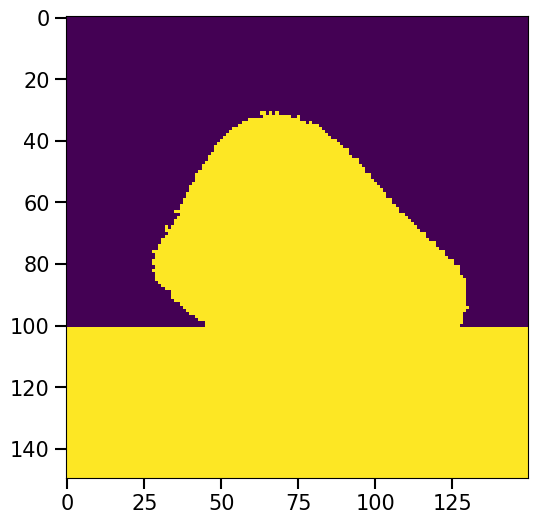

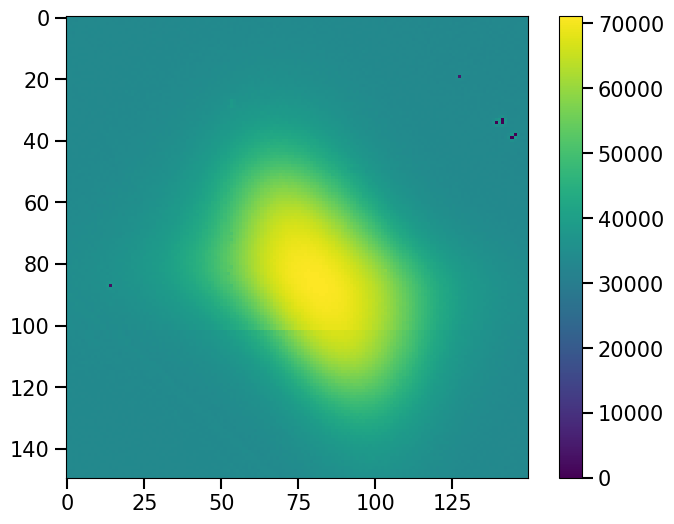

CPU times: user 300 ms, sys: 25 ms, total: 325 ms
Wall time: 326 ms


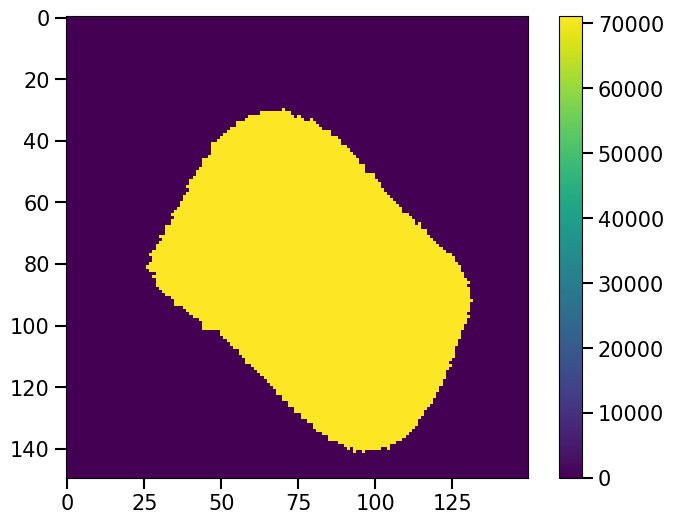

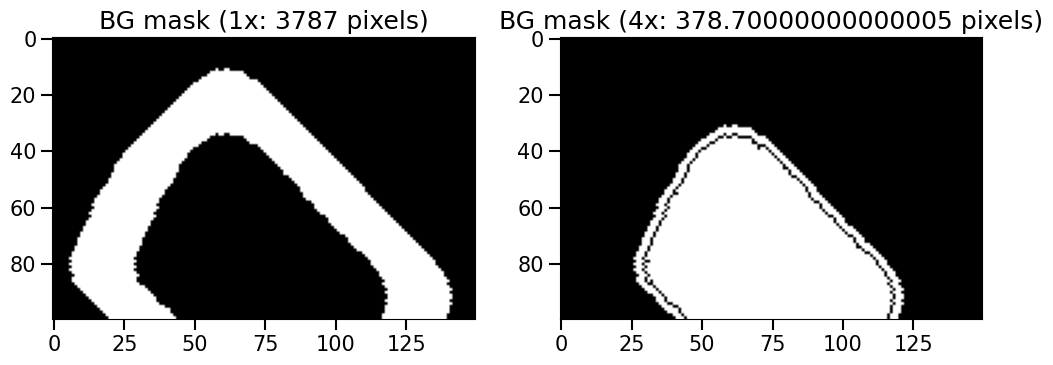

(3787, (100, 150), (100, 150))

In [87]:
import histogram_analysis
# Counting the number of True pixels in the signal mask
true_pixels_count = np.sum(signal_mask)

# Test values for num_pixels
num_pixels_exact = true_pixels_count
num_pixels_double = .1 * true_pixels_count

# Running the create_continuous_buffer function with these test values
continuous_buffer_exact = histogram_analysis.create_continuous_buffer(signal_mask, num_pixels = num_pixels_exact)
continuous_buffer_double = histogram_analysis.create_continuous_buffer(signal_mask, num_pixels = num_pixels_double)

# Visualizing the results
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the result with exact number of pixels
axes[0].imshow(continuous_buffer_exact , cmap='gray')
axes[0].set_title(f'BG mask (1x: {num_pixels_exact} pixels)')

# Plotting the result with double the number of pixels
axes[1].imshow(continuous_buffer_double | signal_mask, cmap='gray')
axes[1].set_title(f'BG mask (4x: {num_pixels_double} pixels)')

plt.show()

true_pixels_count, continuous_buffer_exact.shape, continuous_buffer_double.shape

In [39]:
histograms = calculate_histograms(data, bin_boundaries, hist_start_bin)
average_histogram = get_average_roi_histogram(histograms, roi_x_start, roi_x_end, roi_y_start, roi_y_end)
emd_values = calculate_emd_values(histograms, average_histogram)

null_distribution = generate_null_distribution(histograms, average_histogram, roi_x_start, roi_x_end, roi_y_start, roi_y_end,
                                            1000)

In [40]:
import numpy as np

def average_in_rectangle(arr, xstart, xend, ystart, yend):
    """
    Calculate the average over the last two axes of a 3D array within a specified rectangle.

    :param arr: 3D numpy array.
    :param xstart: Start index on the second-to-last axis.
    :param xend: End index on the second-to-last axis.
    :param ystart: Start index on the last axis.
    :param yend: End index on the last axis.
    :return: Average values for each slice in the first axis.
    """
    # Ensure indices are within the array dimensions
    xstart, xend = max(0, xstart), min(arr.shape[-2], xend)
    ystart, yend = max(0, ystart), min(arr.shape[-1], yend)

    # Extract the sub-array
    sub_array = arr[:, xstart:xend, ystart:yend]

    # Calculate the average
    avg_values = np.mean(sub_array, axis=(-2, -1))

    return avg_values

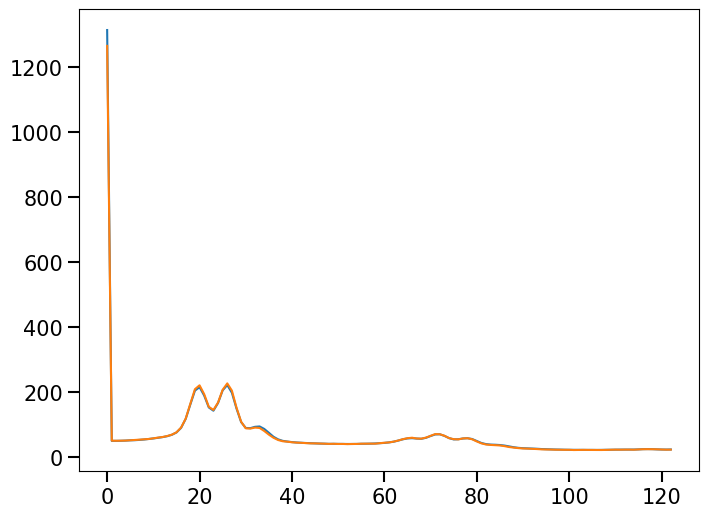

In [41]:
plt.plot(average_in_rectangle(histograms, roi_x_start, roi_x_end, roi_y_start, roi_y_end))
plt.plot(average_in_rectangle(histograms, 0, 30, 0, 30))

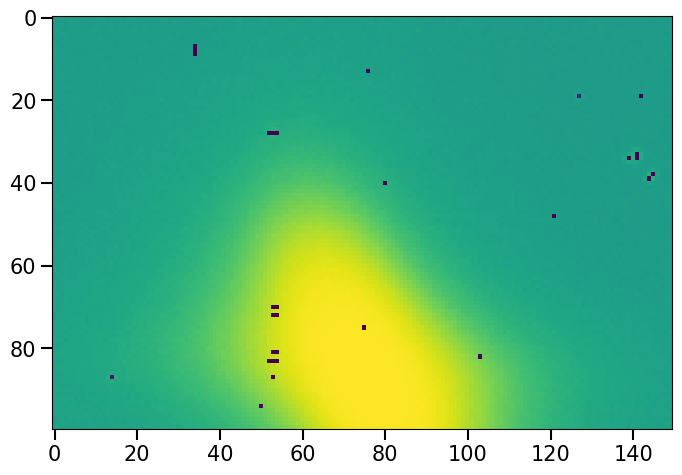

In [42]:
plt.imshow(histograms.mean(axis = 0))

In [43]:
plt.plot(energies,res['average_histogram'])

NameError: name 'energies' is not defined

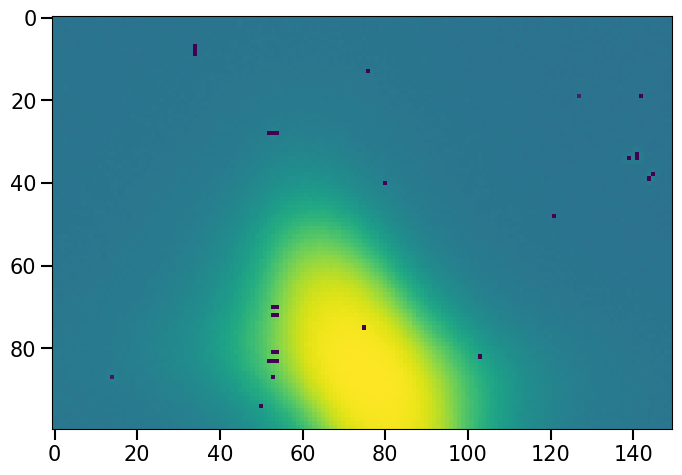

In [44]:
plt.imshow(res['emd_values'])

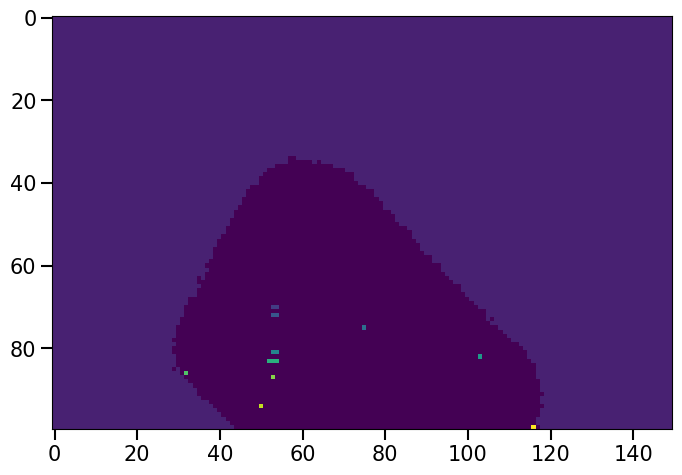

In [45]:
plt.imshow(res['labeled_array'])

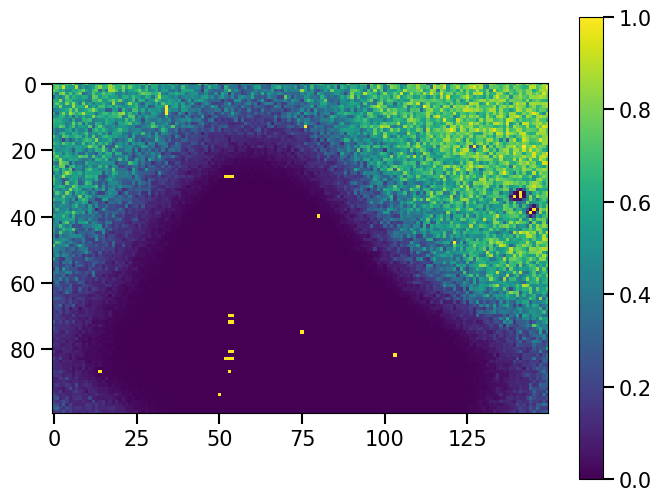

In [46]:
plt.imshow(res['p_values'])
plt.colorbar()

/tmp/ipykernel_2518718/4172320479.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(1 - np.log(res['p_values']))


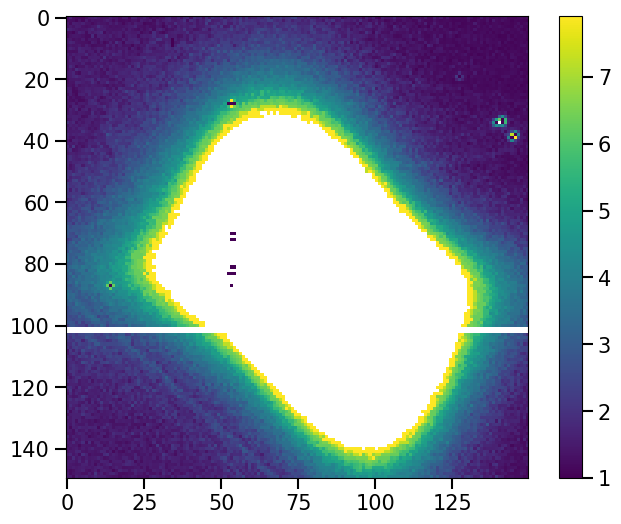

In [109]:
plt.imshow(1 - np.log(res['p_values']))
plt.colorbar()

[]

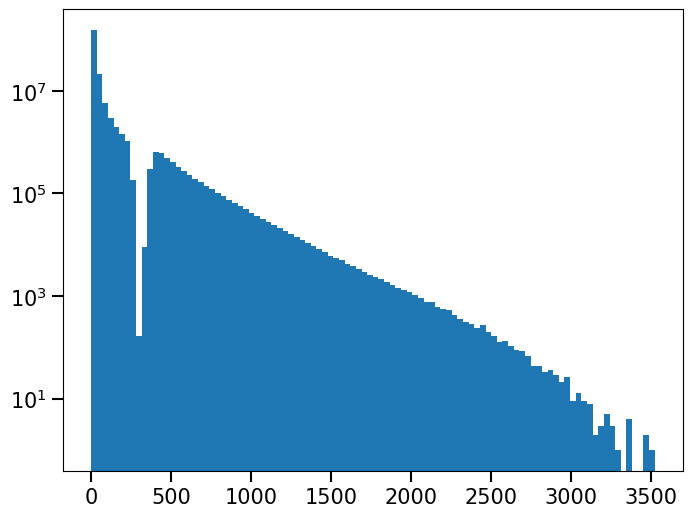

In [47]:
plt.hist(data[data > 0], bins = 100);
plt.semilogy()

In [51]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def plot_heatmap_with_roi(data, roi_x_start, roi_x_end, roi_y_start, roi_y_end):
    # Integrate data over the 0th axis
    integrated_data = data.mean(axis=0)

    # Create the heatmap
    plt.imshow(integrated_data, cmap='hot', interpolation='nearest')

    # Create a Rectangle patch
    rect = patches.Rectangle((roi_y_start, roi_x_start), roi_y_end - roi_y_start, roi_x_end - roi_x_start,
                             linewidth=1, edgecolor='blue', facecolor='none')

    # Add the patch to the Axes
    plt.gca().add_patch(rect)

    plt.colorbar()  # Add a colorbar to a plot
    plt.title("Heatmap with ROI Box")
    plt.xlabel("Y Axis")

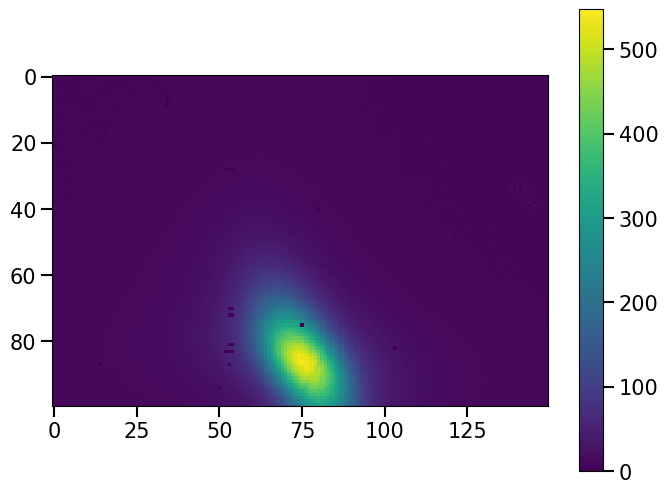

In [52]:
plt.imshow(data.mean(axis = 0))
plt.colorbar()

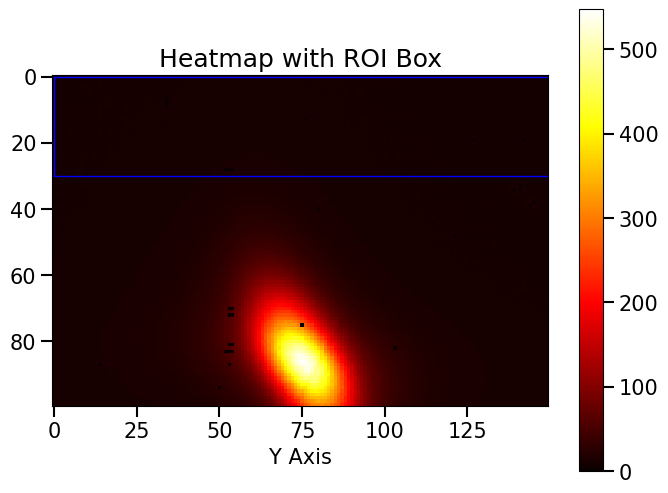

In [53]:
plot_heatmap_with_roi(data, roi_x_start, roi_x_end, roi_y_start, roi_y_end)

In [54]:
import pump_probe

In [63]:
%%time

from importlib import reload
reload(pump_probe)

histogram_analysis.Emin = -np.inf
histogram_analysis.Emax = np.inf

# Set random seed so that we get the same signal mask when rerunning the notebook. Ultimately,
# we would want to pick some sort of reproducible 'majority vote' mask based on many runs with
# different seeds
np.random.seed(2)
signal_mask = pump_probe.compute_signal_mask(bin_boundaries, hist_start_bin, roi_coordinates, .001,
                                             histograms = histograms)

cdw_data = pump_probe.generate_plot_data(cdw_output, signal_mask, bin_boundaries,
                              hist_start_bin, roi_coordinates, 1)

CPU times: user 2.56 s, sys: 136 ms, total: 2.69 s
Wall time: 2.71 s


/sdf/data/lcls/ds/xpp/xppx1003221/results/ohoidn/Shift 4/plots.py:36: RuntimeWarning: divide by zero encountered in log
  return np.exp(np.mean(np.log(arr)))


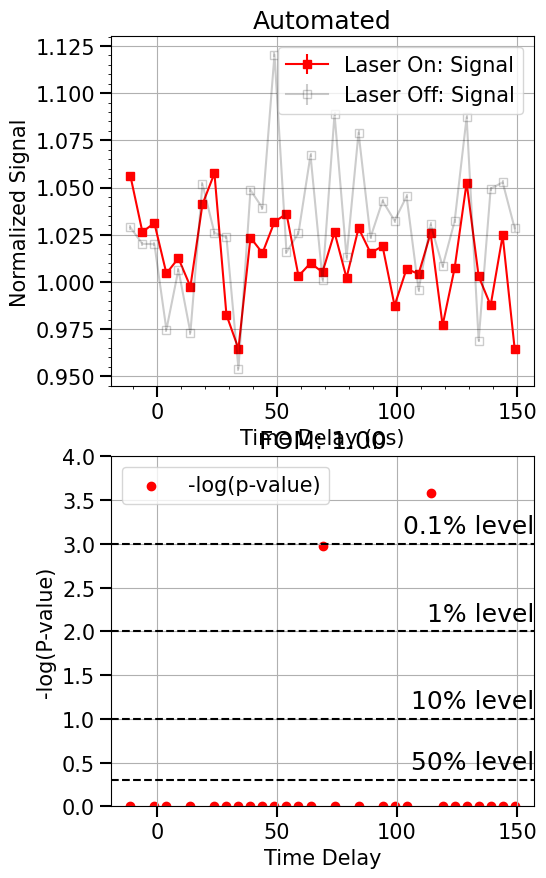

In [64]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(12, 10))
gs = GridSpec(2, 2, figure=fig)
pump_probe.plot_data(cdw_data, subplot_spec=[gs[0, 1], gs[1, 1]], plot_title = 'Automated')